# DoS in a VANET

In [1]:
import os
import sys
import nashpy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

import multiprocessing
from joblib import delayed
from joblib import Parallel

In [2]:
# ASSUMPTIONS
    # [1] Performance Evaluation in Misbehaviour Detection Techniques for DoS Attacks in VANETs
C = 6000 # [1]
w = 0.1
gm = 0.2
v0 = 130 # (*) highway speed in ITALY
lambda_pois = 3000

In [3]:
def payoff_attack(atk_rate, atk_tau, atk_C, atk_o, atk_g, atk_v0, atk_v1, atk_lbd):
    
    if stats.poisson.cdf(k = atk_tau, mu = atk_lbd) > 0.5:
        rt = atk_rate
    else:
        rt = 0
        
    ###part1 = (rt/atk_tau) - atk_o - atk_g
    part1 = np.multiply(np.divide(atk_tau, atk_C),
                        np.divide(rt, atk_C)) - atk_o - atk_g
    ###delta_v = np.exp(((atk_v0 - atk_v1) / atk_v0)) - 1
    delta_v = (atk_v0 - atk_v1) / atk_v0
    
    return (part1 + delta_v)#.astype(np.float32)

payoff_attack = np.vectorize(payoff_attack)

In [4]:
def payoff_defense(def_rate, def_tau, def_C, def_v0, def_v1, def_lbd):
    
    if stats.poisson.cdf(k = def_tau, mu = def_lbd) > 0.5:
        rt = def_rate
    else:
        rt = 0
    
    delta_v = ((def_v0 - def_v1) / def_v0)
    part1 = 1 - np.multiply(np.divide(def_tau, def_C), np.divide(rt, def_C))
    part2 = np.power(np.divide(def_tau, def_C) - (1/2), 2) # performance of VANET
    
    return part1 - part2 - delta_v#.astype(np.float32) # a-b-c

payoff_defense = np.vectorize(payoff_defense)

In [ ]:
#x = np.linspace(-1, 1, num = 1000)
#plt.plot(x, np.power(x, 3))
#plt.plot(x, x)
#plt.axvline(0, color = "grey", alpha = .5, ls = "--")
#plt.axhline(0, color = "grey", alpha = .5, ls = "--")


#plt.plot(x, ((x/6000)-0.5)**2, label = "$f(x)^2$")
#plt.plot(x, np.abs((x/6000)-0.5), label = "$|f(x)|$")
#plt.legend()
#plt.show()

In [5]:
def Simulation(sim_C, sim_omega, sim_gamma, sim_v0, sim_rate_list = None,
               sim_tau_list = None, sim_v1_list = None, sim_poiss_mu = 50):
    """
    Parameters
    ----------
    
    sim_rate_list : iterable
    sim_tau_list : iterable
    sim_v1_list : iterable
    """
    output_payoff = []
    output_strategy = []
    
    if sim_tau_list is None:
        sim_tau_list = np.arange(200, 1001, 100)
    if sim_rate_list is None:
        sim_rate_list = np.arange(200, 1001, 100)
    if sim_v1_list is None:
        sim_v1_list = np.arange(v0 - 30, v0 + 30, 10)
    
    for v1 in sim_v1_list:

        ATK = np.array([payoff_attack(atk_rate = r, atk_tau = sim_tau_list, atk_C = sim_C,
                                      atk_o = sim_omega, atk_g = sim_gamma, atk_v0 = sim_v0,
                                      atk_v1 = v1, atk_lbd = sim_poiss_mu)
                        for r in sim_rate_list])
        DEF = np.array([payoff_defense(def_rate = r, def_tau = sim_tau_list, def_C = sim_C,
                                       def_v0 = sim_v0, def_v1 = v1, def_lbd = sim_poiss_mu)
                        for r in sim_rate_list])

        game = nashpy.Game(ATK, DEF)
        
        equilibria = []
        for eq in game.support_enumeration():
            
            iter_ = eq
            
            br_player1 = iter_[0].argmax()
            br_player2 = iter_[1].argmax()
            
            # Payoffs
            output_payoff += [[v1,
                               ATK[br_player1, br_player2],
                               DEF[br_player1, br_player2]]]            
            # Strategies
            output_strategy += [[v1, sim_rate_list[br_player1], sim_tau_list[br_player2]]]
            
    return output_payoff, output_strategy

In [6]:
def big_payoff_matrices(big_range_r, big_range_t, big_C, big_omega, big_gamma, big_v1, big_l):
    
    attacker = np.array([payoff_attack(atk_rate = r, atk_tau = big_range_t, atk_C = big_C,
                                       atk_o = big_omega, atk_g = big_gamma, atk_v0 = v0,
                                       atk_v1 = big_v1, atk_lbd = big_l)
                         for r in big_range_r])
    defender = np.array([payoff_defense(def_rate = r, def_tau = big_range_t,
                                        def_C = big_C, def_v0 = v0,
                                        def_v1 = big_v1, def_lbd = big_l)
                         for r in big_range_r])
    
    return attacker, defender

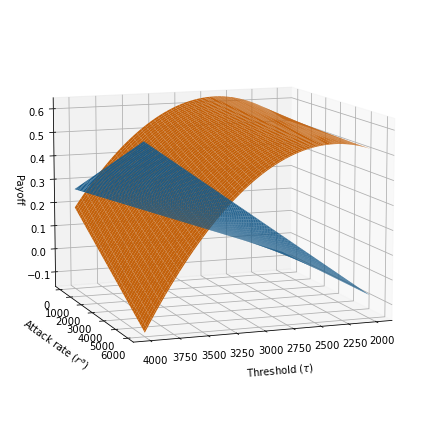

In [8]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"}, figsize = (8, 6))

X = np.linspace(2000, 4000, num = 100)
Y = np.linspace(1, 6000, num = 100)

Z1, Z2 = big_payoff_matrices(big_range_r = X, big_range_t = Y, big_C = C,
                             big_omega = w, big_gamma = gm, big_v1 = 100,
                             big_l = 50)

X, Y = np.meshgrid(X, Y)

surf1 = ax.plot_surface(X, Y, Z1) # attacker
surf2 = ax.plot_surface(X, Y, Z2) # RSU

ax.set_xlabel("Threshold (${\\tau}$)", labelpad = 10)
ax.set_ylabel("Attack rate ($r^{a}$)", labelpad = 10)
ax.set_zlabel("Payoff")

#plt.suptitle("Payoff surfaces; $v_1$ = 100")
#ax.legend()

ax.view_init(10, 70)
plt.tight_layout()
# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
#plt.savefig("./images/surfaces.png", dpi = 300)

In [9]:
n_cores = min(multiprocessing.cpu_count(), 8) # don't use more than 8 cores

simul = Parallel(n_jobs = n_cores)(delayed(lambda v:
                                           Simulation(sim_C = C, sim_omega = w, sim_gamma = gm, sim_v0 = v0,
                                                      sim_rate_list = np.linspace(2000, 4000,
                                                                                  #lambda_pois - 200,
                                                                                  #lambda_pois + 200,
                                                                                  num = 8, dtype = np.int32),
                                                      sim_tau_list = np.linspace(1, 6000, num = 8, # 1000, 4000
                                                                                 dtype = np.int32),
                                                      sim_v1_list = [v], sim_poiss_mu = 50))(v)
                                           for v in [40, 70, 100, 130, 160, 180])

o_pfs = [simul[i][0] for i in range(len(simul))]
o_str = [simul[i][1] for i in range(len(simul))]

print(o_pfs)
print(o_str)

[[[40, 0.4876410256410256, 0.08490997435897452]], [[70, 0.2568717948717949, 0.31567920512820524]], [[100, 0.02610256410256409, 0.546448435897436]], [[130, -0.2046666666666667, 0.7772176666666668]], [[160, -0.4354358974358975, 1.0079868974358976]], [[180, -0.5892820512820514, 1.1618330512820514]]]
[[[40, 4000, 858]], [[70, 4000, 858]], [[100, 4000, 858]], [[130, 4000, 858]], [[160, 4000, 858]], [[180, 4000, 858]]]


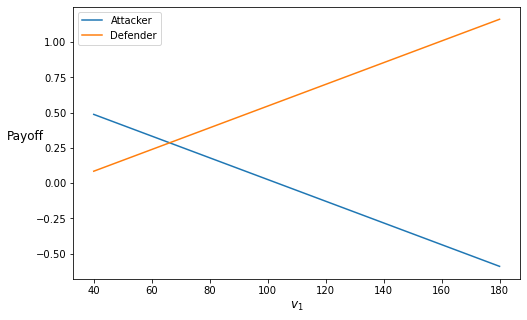

In [10]:
pd.DataFrame(np.vstack([np.array(c) for c in o_pfs]),
             columns = ["V1", "Attacker", "Defender"]).set_index("V1").plot(figsize = (8, 5))

plt.ylabel("Payoff", rotation = 0, labelpad = 10, fontsize = 12)
plt.xlabel("$v_1$", fontsize = 12)

plt.show()
#plt.savefig("./images/NE_payoff_speed.png", dpi = 300)

In [11]:
pd.DataFrame(np.vstack([np.array(c) for c in o_str]),
             columns = ["V1", "Attacker", "Defender"])

,V1,Attacker,Defender
0,40,4000,858
1,70,4000,858
2,100,4000,858
3,130,4000,858
4,160,4000,858
5,180,4000,858


---
---

## Repeated game ($\infty$ times)

In [12]:
# Fix new v1 to 100
rep_v1 = 130

In [13]:
def RepeatedGameINF(rep_inf_rates, rep_inf_taus, rep_inf_C, rep_inf_o,
                    rep_inf_g, rep_inf_v0, rep_inf_v1, rep_inf_lbd,
                    rep_inf_discount, deviation = False):
    """
    Parameters
    ----------
    
    rep2_rates: iterable of length 2
    rep2_taus: iterable of length 2
    """
    payoff_array_A = [payoff_attack(atk_rate = rep_inf_rates[s],
                                    atk_tau = rep_inf_taus[s],
                                    atk_C = rep_inf_C, atk_o = rep_inf_o,
                                    atk_g = rep_inf_g, atk_v0 = rep_inf_v0,
                                    atk_v1 = rep_inf_v1, atk_lbd = rep_inf_lbd)
                      for s in range(len(rep_inf_rates))]
    
    payoff_array_D = [payoff_defense(def_rate = rep_inf_rates[s],
                                     def_tau = rep_inf_taus[s],
                                     def_C = rep_inf_C, def_v0 = rep_inf_v0,
                                     def_v1 = rep_inf_v1, def_lbd = rep_inf_lbd)
                      for s in range(len(rep_inf_rates))]
    
    if deviation == False:
        # Compute payoff with geometric series
        # with payoff of "agreement"
        payoff_A = payoff_array_A[0] / (1 - rep_inf_discount)
        payoff_D = payoff_array_D[0] / (1 - rep_inf_discount)
        
        return payoff_A, payoff_D
    
    else:
        # First game is deviation
        # all the others are retaliations
        
        payoff_A = payoff_array_A[0] +\
                   np.divide(np.multiply(payoff_array_A[1], rep_inf_discount),
                             1 - rep_inf_discount)
        
        payoff_D = payoff_array_D[0] +\
                   np.divide(np.multiply(payoff_array_D[1], rep_inf_discount),
                             1 - rep_inf_discount)
        
        return payoff_A, payoff_D

In [14]:
# SIMULATE DIFFERENT GRT STRATEGIES
delta_range_repinf_grt = np.linspace(0.01, 0.99, 20)
data_delta = []
for grt_attack in np.linspace(0, 3000, 50):
    for grt_defense in np.linspace(0, 3000, 50):

        iter_agreement = [RepeatedGameINF([grt_attack], [grt_defense], rep_inf_C = C, rep_inf_o = w,
                                          rep_inf_g = gm, rep_inf_v0 = v0, rep_inf_v1 = rep_v1,
                                          rep_inf_lbd = 50, rep_inf_discount = d, deviation = False)
                          for d in delta_range_repinf_grt]

        iter_deviation = [RepeatedGameINF([4000, 4000], [grt_defense, 858/2], rep_inf_C = C, rep_inf_o = w,
                                          rep_inf_g = gm, rep_inf_v0 = v0, rep_inf_v1 = rep_v1,
                                          rep_inf_lbd = 50, rep_inf_discount = d, deviation = True)
                          for d in delta_range_repinf_grt]


        iter_agreement = pd.DataFrame(iter_agreement, index = np.linspace(0.01, 0.99, 20))
        iter_deviation = pd.DataFrame(iter_deviation, index = np.linspace(0.01, 0.99, 20))

        # When the agreement is more convenient for the attacker
        # (he is more likely to deviate, because lower rates favor the defender)
        delta_agreement = delta_range_repinf_grt[np.where(iter_agreement[0] > iter_deviation[0])]
        if len(delta_agreement) == 0:
            delta_grt_min = np.nan
            delta_grt_max = np.nan
            
            data_delta += [[grt_attack, grt_defense, delta_grt_min, delta_grt_max]]
        else:
            delta_grt_min = delta_agreement.min()
            delta_grt_max = delta_agreement.max()
            
            data_delta += [[grt_attack, grt_defense, delta_grt_min, delta_grt_max]]
            
            #print("A: {}, D: {}\nDelta for agreement\n\t min: {}; max: {}".format(grt_attack, grt_defense,
            #                                                                      delta_grt_min, delta_grt_max))
            #print()
            #print()

In [15]:
delta_prova = pd.DataFrame(np.array(data_delta).astype(np.float32),
                           columns = ["Attacker", "Defender", "Delta min", "Delta max"])
delta_prova["Attacker"] = delta_prova["Attacker"].astype(int)
delta_prova["Defender"] = delta_prova["Defender"].astype(int)
delta_prova["Delta min"] = delta_prova["Delta min"].apply(lambda v: v if pd.isnull(v) else np.round(v, 2))
delta_prova["Delta max"] = delta_prova["Delta max"].apply(lambda v: v if pd.isnull(v) else np.round(v, 2))

In [32]:
delta_prova.pivot_table(index = "Attacker", columns = "Defender",
                        values = "Delta min", aggfunc = np.nanmean).min() # per column

np.argmin(delta_prova.pivot_table(index = "Attacker", columns = "Defender",
                        values = "Delta min", aggfunc = np.nanmean).min()) # overall

23

In [35]:
delta_prova.pivot_table(index = "Attacker", columns = "Defender",
                        values = "Delta min", aggfunc = np.nanmean).iloc[-1, 23]

0.32

In [37]:
delta_prova.pivot_table(index = "Attacker", columns = "Defender",
                        values = "Delta min", aggfunc = np.nanmean).loc[3000, 2020]

0.32

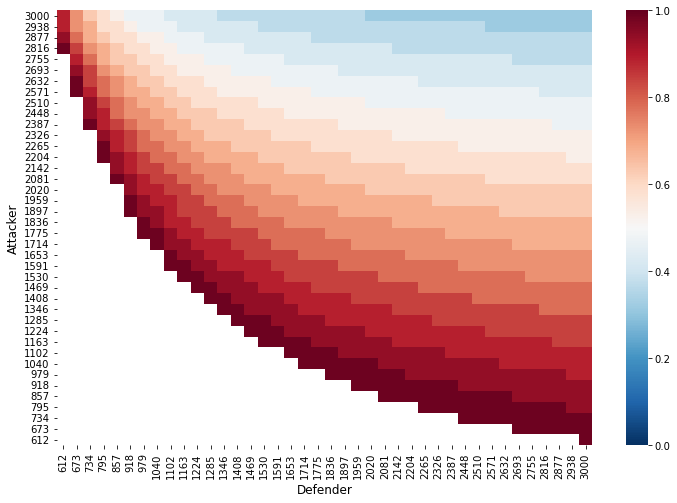

In [17]:
plt.figure(figsize = (12, 8))
sns.heatmap(delta_prova.pivot_table(index = "Attacker", columns = "Defender",
                                    values = "Delta min", aggfunc = np.nanmean)[::-1],
           xticklabels = True, cmap = "RdBu_r", vmin = 0, vmax = 1)
plt.xlabel("Defender", fontsize = 12, labelpad = 5)
plt.ylabel("Attacker", fontsize = 12)

#plt.xlim(4, 50)
plt.show()
#plt.savefig("./images/delta_agreement.png", dpi = 300)

14
20


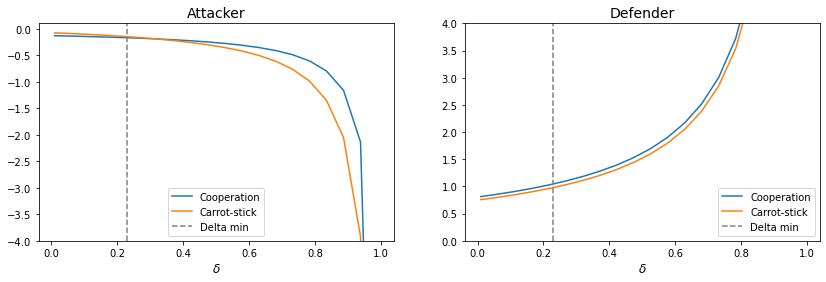

In [50]:
# DEFENDER: if the outcome of the first game is not (2900, 2900) set
#           new tau always equal to the value before in the array used
#           before, i.e. 858.

repinf_stable = [RepeatedGameINF([3000], [2020], rep_inf_C = C, rep_inf_o = w,
                                 rep_inf_g = gm, rep_inf_v0 = v0, rep_inf_v1 = rep_v1,
                                 rep_inf_lbd = 50, rep_inf_discount = d, deviation = False)
                 for d in np.linspace(0.01, 0.99, 20)]

repinf_deviation = [RepeatedGameINF([4000, 4000], [2020, 858/2], rep_inf_C = C, rep_inf_o = w,
                                    rep_inf_g = gm, rep_inf_v0 = v0, rep_inf_v1 = rep_v1,
                                    rep_inf_lbd = 50, rep_inf_discount = d, deviation = True)
                    for d in np.linspace(0.01, 0.99, 20)]


repinf_stable = pd.DataFrame(repinf_stable, index = np.linspace(0.01, 0.99, 20))
repinf_deviation = pd.DataFrame(repinf_deviation, index = np.linspace(0.01, 0.99, 20))


rep_inf_fig, rep_inf_ax = plt.subplots(1, 2, figsize = (14, 4))
rep_inf_ax[0].plot(repinf_stable.drop(1, axis = 1), label = "Cooperation")
rep_inf_ax[0].plot(repinf_deviation.drop(1, axis = 1), label = "Carrot-stick")
rep_inf_ax[0].axvline(0.23, color = "grey", ls = "--", label = "Delta min")
rep_inf_ax[0].legend()
rep_inf_ax[0].set_title("Attacker", fontsize = 14)
rep_inf_ax[0].set_xlabel("$\delta$", fontsize = 12)
rep_inf_ax[0].set_ylim(-4, 0.1)


rep_inf_ax[1].plot(repinf_stable.drop(0, axis = 1), label = "Cooperation")
rep_inf_ax[1].plot(repinf_deviation.drop(0, axis = 1), label = "Carrot-stick")
rep_inf_ax[1].axvline(0.23, color = "grey", ls = "--", label = "Delta min")
rep_inf_ax[1].legend()
rep_inf_ax[1].set_title("Defender", fontsize = 14)
rep_inf_ax[1].set_xlabel("$\delta$", fontsize = 12)
rep_inf_ax[1].set_ylim(0, 4)

print(np.sum(repinf_stable[0] > repinf_deviation[0]))
print(np.sum(repinf_stable[1] > repinf_deviation[1]))

plt.show()
#plt.savefig("./images/delta_min.jpg", dpi = 300)

---
---
---